# OCR model for reading Captchas

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2020/06/14<br>
**Last modified:** 2020/06/26<br>
**Description:** How to implement an OCR model using CNNs, RNNs and CTC loss.

## Introduction

This example demonstrates a simple OCR model built with the Functional API. Apart from
combining CNN and RNN, it also illustrates how you can instantiate a new layer
and use it as an "Endpoint layer" for implementing CTC loss. For a detailed
guide to layer subclassing, please check out
[this page](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)
in the developer guides.

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Load the data: [Captcha Images](https://www.kaggle.com/fournierp/captcha-version-2-images)
Let's download the data.

In [2]:
DATA_DIR='./good'

In [3]:
! rm -rf ./good
! tar -xf ./good.tar.gz


The dataset contains 1040 captcha files as `png` images. The label for each sample is a string,
the name of the file (minus the file extension).
We will map each character in the string to an integer for training the model. Similary,
we will need to map the predictions of the model back to strings. For this purpose
we will maintain two dictionaries, mapping characters to integers, and integers to characters,
respectively.

In [4]:
# Path to the data directory
data_dir = Path('./good')

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 150
img_height = 80

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 2

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
max_length
# characters=['m', 'u', 'g', 'x', 'b', 'e', 'f', '4', 'y', 'd', '9', 'w', 's', 'q', '3', 'p', 'j', 'z', '1', '8', 'r', '6', '5', 'l', 'i', 'n', 't', 'c', '7', 'a', 'h', '2', 'v', 'k']



Number of images found:  5218
Number of labels found:  5218
Number of unique characters:  10
Characters present:  {'0', '9', '1', '2', '3', '5', '8', '6', '7', '4'}


5

## Preprocessing

In [5]:
characters=['2', '6', '9', '8', '1', '5', '0', '4', '3', '7']
print("Number of unique characters: ", len(characters))

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.8, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_jpeg(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


Number of unique characters:  10


2022-07-21 14:09:13.009525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 14:09:13.047938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 14:09:13.048118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 14:09:13.048830: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Create `Dataset` objects

In [6]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [7]:
!nvidia-smi

Thu Jul 21 14:01:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 24%   48C    P2    25W / 100W |   2860MiB /  4096MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Visualize the data

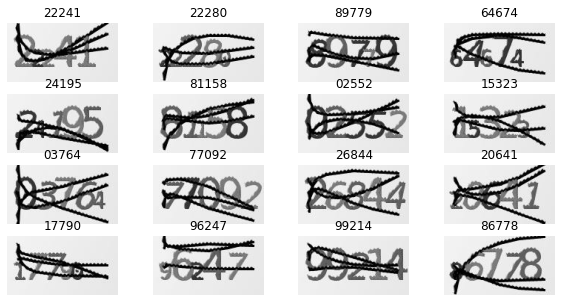

In [7]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model

In [8]:
@tf.keras.utils.register_keras_serializable()
class CTCLayer(layers.Layer):  
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

    def get_config(self):
        config = super(CTCLayer, self).get_config()
        config.update({
            'loss_fn': self.loss_fn
        })
        return config


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Nadam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 150, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 80, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 75, 40, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 75, 40, 64)   18496       ['pool1[0][0]']       

In [9]:
def get_graph(history):
  plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
  plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print('min val_loss:',min(history.history['val_loss']))

## Training

In [10]:

epochs = 100
early_stopping_patience = 5
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100


2022-07-21 14:09:51.266950: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-07-21 14:09:51.807775: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


261/261 [==============================] - 13s 26ms/step - loss: 13.8419 - val_loss: 13.2833
Epoch 2/100
261/261 [==============================] - 6s 21ms/step - loss: 13.0598 - val_loss: 12.5037
Epoch 3/100
261/261 [==============================] - 6s 21ms/step - loss: 9.7180 - val_loss: 3.9916
Epoch 4/100
261/261 [==============================] - 5s 21ms/step - loss: 1.8495 - val_loss: 0.3531
Epoch 5/100
261/261 [==============================] - 5s 21ms/step - loss: 0.5514 - val_loss: 0.1984
Epoch 6/100
261/261 [==============================] - 6s 21ms/step - loss: 0.3080 - val_loss: 0.1155
Epoch 7/100
261/261 [==============================] - 5s 21ms/step - loss: 0.2197 - val_loss: 0.0870
Epoch 8/100
261/261 [==============================] - 5s 21ms/step - loss: 0.1675 - val_loss: 0.0491
Epoch 9/100
261/261 [==============================] - 6s 21ms/step - loss: 0.1355 - val_loss: 0.0552
Epoch 10/100
261/261 [==============================] - 5s 21ms/step - loss: 0.1051 - val

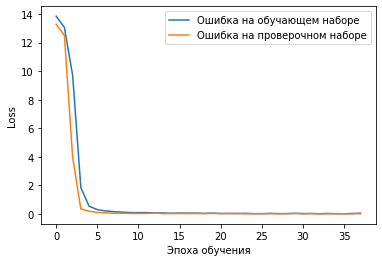

min val_loss: 0.008946350775659084


In [11]:
get_graph(history)

Epoch 1/10
261/261 [==============================] - 11s 25ms/step - loss: 0.0118 - val_loss: 0.0080
Epoch 2/10
261/261 [==============================] - 6s 21ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 3/10
261/261 [==============================] - 5s 21ms/step - loss: 0.0084 - val_loss: 0.0057
Epoch 4/10
261/261 [==============================] - 5s 21ms/step - loss: 0.0088 - val_loss: 0.0074
Epoch 5/10
261/261 [==============================] - 5s 21ms/step - loss: 0.0047 - val_loss: 0.0065
Epoch 6/10
261/261 [==============================] - 5s 21ms/step - loss: 0.0054 - val_loss: 0.0079
Epoch 7/10
261/261 [==============================] - 5s 21ms/step - loss: 0.0078 - val_loss: 0.0043
Epoch 8/10
261/261 [==============================] - 5s 21ms/step - loss: 0.0045 - val_loss: 0.0064
Epoch 9/10
261/261 [==============================] - 6s 21ms/step - loss: 0.0041 - val_loss: 0.0065
Epoch 10/10
261/261 [==============================] - 5s 21ms/step - loss: 0.0035 - val_l

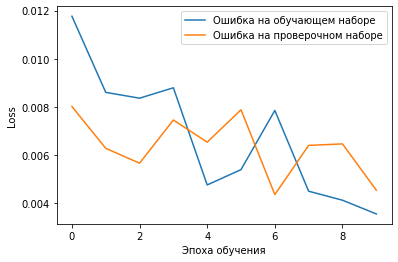

min val_loss: 0.004347676876932383


In [12]:
opt = keras.optimizers.Nadam(learning_rate=0.0001)
model.compile(optimizer=opt)

epochs = 10
early_stopping_patience = 5
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=DATA_DIR + '/best_model.h5',
    save_best_only=True,
    monitor="val_loss"
    )

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint],
)
get_graph(history)

## Inference

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 150, 80, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 150, 80, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 40, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 75, 40, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 37, 20, 64)        0         
                                                                 
 reshape (Reshape)           (None, 37, 1280)          0         
                                                                 
 dense1 (Dense)              (None, 37, 64)            81984 

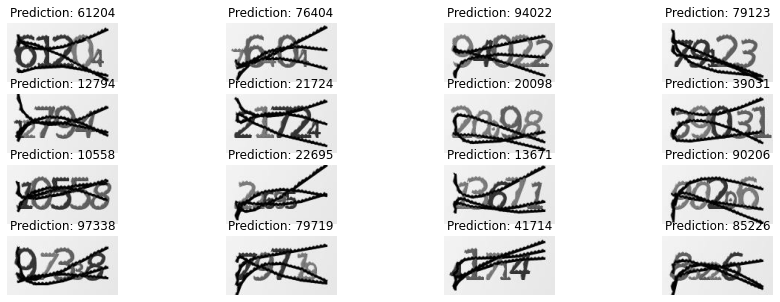

In [13]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [14]:
import h5py
prediction_model.compile()
prediction_model.save("./pred_model_gibdd.h5")
model.save(DATA_DIR+"./model_hibdd.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 150, 80, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 150, 80, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 40, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 75, 40, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 37, 20, 64)        0         
                                                                 
 reshape (Reshape)           (None, 37, 1280)          0         
                                                                 
 dense1 (Dense)              (None, 37, 64)            81984 

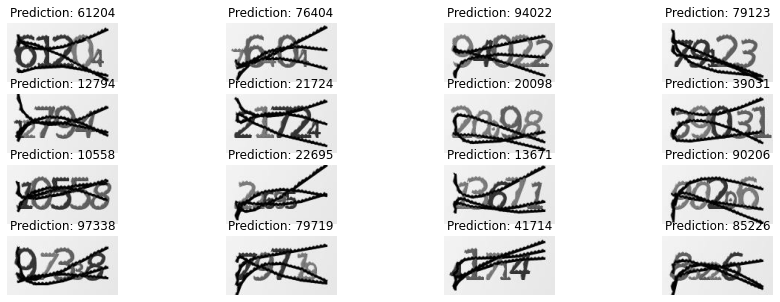

In [16]:
# Get the prediction model by extracting layers till the output layer
# prediction_model = keras.models.Model(
    # model_new.get_layer(name="image").input, model_new.get_layer(name="dense2").output
# )
from keras.models import load_model
prediction_model = load_model("./pred_model_gibdd.h5")
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    # print(preds)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

(80, 150, 1)


['70718']

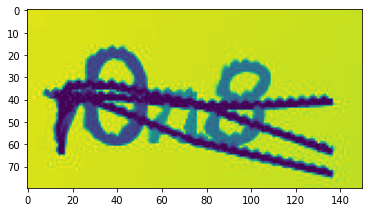

In [19]:
f='bad/0n8.jpg'
img = tf.io.read_file(f)
    # 2. Decode and convert to grayscale
img1 = tf.io.decode_jpeg(img, channels=1)
print(img1.shape)
# 3. Convert to float32 in [0, 1] range
img = tf.image.convert_image_dtype(img1, tf.float32)
# 4. Resize to the desired size
img = tf.image.resize(img, [img_height, img_width])
# 5. Transpose the image because we want the time
# dimension to correspond to the width of the image.
img = tf.transpose(img, perm=[1, 0, 2])
# batch_images=cv2.imread('/content/emt/1996m8.jpg')
image=np.expand_dims(img, axis=0)

preds = prediction_model.predict(image)

pred_texts = decode_batch_predictions(preds)
plt.imshow(img1)
pred_texts


In [20]:
model.evaluate(train_dataset)

261/261 [==============================] - 3s 12ms/step - loss: 2.0789e-04


0.00020789429254364222